# <code>MASKRCNN</code> implementation

In [9]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2

class LiveCellDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        
        # Define transforms if none provided
        if transforms is None:
             self.transforms = A.Compose([
                A.Resize(512, 512),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))
        else:
            self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        # 1. Get Image Info
        img_id = self.ids[index]
        coco = self.coco
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        
        # 2. Load Image
        cell_type = file_name.split('_')[0]
        full_path = os.path.join(self.root_dir, file_name)
        if not os.path.exists(full_path):
             full_path = os.path.join(self.root_dir, cell_type, file_name)

        img = cv2.imread(full_path)
        if img is None:
            # Failsafe: Return a blank image to prevent crash, but print warning
            print(f"Warning: Could not find {full_path}")
            img = np.zeros((512, 512, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 3. Get Annotations & Convert to Boxes
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        
        boxes = []
        labels = []
        for ann in anns:
            # COCO bbox: [x, y, w, h]
            # Skip tiny/invalid boxes
            if ann['bbox'][2] > 1 and ann['bbox'][3] > 1:
                boxes.append(ann['bbox'])
                labels.append(1) # Class 1 = Cell

        # 4. Apply Transforms
        if self.transforms:
            try:
                transformed = self.transforms(image=img, bboxes=boxes, category_ids=labels)
                img_tensor = transformed['image']
                boxes = transformed['bboxes']
                labels = transformed['category_ids']
            except ValueError:
                # Fallback for empty images or bad boxes
                img_tensor = ToTensorV2()(image=img)['image']
                boxes = []
                labels = []

        # 5. FORMAT TARGET FOR MASK R-CNN (The Fix)
        target = {}
        
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # Convert xywh -> xyxy
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            
            # --- NEW: GENERATE MASKS ---
            # Mask R-CNN expects a UInt8 Tensor of shape [N, H, W]
            # We need to extract the mask for EACH annotation/box
            masks = []
            for ann in anns:
                # Skip invalid boxes like we did before
                if ann['bbox'][2] > 1 and ann['bbox'][3] > 1:
                    # annToMask generates a binary mask for ONE cell
                    mask = coco.annToMask(ann)
                    masks.append(mask)
            
            if len(masks) > 0:
                masks = np.stack(masks, axis=0)
                masks = torch.as_tensor(masks, dtype=torch.uint8)
            else:
                # Handle edge case where boxes passed check but masks didn't
                masks = torch.zeros((0, img_info['height'], img_info['width']), dtype=torch.uint8)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            masks = torch.zeros((0, img_info['height'], img_info['width']), dtype=torch.uint8)

        target["boxes"] = boxes
        target["labels"] = torch.ones((len(boxes),), dtype=torch.int64)
        target["image_id"] = torch.tensor([index])
        target["masks"] = masks
        
        # Optional: Area and Iscrowd (good for eval, not strict for training)
        if len(boxes) > 0:
             target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
             target["area"] = torch.as_tensor([], dtype=torch.float32)
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        return img_tensor, target


In [ ]:
train_dataset = LiveCellDataset(root_dir = "dataset/images 2/livecell_train_val_images",annotation_file='jsons/livecell_coco_train.json')
test_dataset = LiveCellDataset(root_dir = "dataset/images 2/livecell_test_images",annotation_file='jsons/livecell_coco_test.json')
val_dataset = LiveCellDataset(root_dir = "dataset/images 2/livecell_train_val_images",annotation_file='jsons/livecell_coco_val.json')

loading annotations into memory...
Done (t=5.67s)
creating index...
index created!
loading annotations into memory...
Done (t=1.55s)
creating index...
index created!
loading annotations into memory...
Done (t=2.34s)
creating index...
index created!


# Phase 2 Training Pipeline

In [11]:
import os
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import DataLoader

In [12]:
def get_model(num_classes):
    # 1. Load pre-trained Mask R-CNN (ResNet50 backbone)
    # weights='DEFAULT' loads the COCO weights (Transfer Learning)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')

    # 2. Replace the Head (Classifier)
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 3. Replace the Mask Predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer, num_classes)
    return model

In [13]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    
    running_loss = 0.0
    for i, (images, targets) in enumerate(data_loader):
        # Move to GPU
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass (Mask R-CNN calculates loss automatically during training)
        loss_dict = model(images, targets)
        
        # Sum up all losses (Box classification + Box regression + Mask prediction)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

        if i % print_freq == 0:
            print(f"Epoch [{epoch}] Iter [{i}/{len(data_loader)}] Loss: {losses.item():.4f}")

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch} Finished. Average Loss: {epoch_loss:.4f}")
    return epoch_loss


In [16]:
OUTPUT_DIR = './checkpoints'
BATCH_SIZE = 4  # Reduce to 2 if you run out of GPU memory
NUM_EPOCHS = 10  # Start small to test pipeline
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Experiment Mode - **Naive**

In [19]:
def custom_collate(batch):
    return tuple(zip(*batch))

os.makedirs(OUTPUT_DIR, exist_ok=True)
dataset = train_dataset
#Use a subset for testing the code first (e.g., first 50 images)
subset_indices = torch.arange(1200)
dataset = torch.utils.data.Subset(dataset, subset_indices)




data_loader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    collate_fn=custom_collate
)

# 2. Setup Model
# 2 classes: Background (0) + Cell (1)
model = get_model(num_classes=2)
model.to(DEVICE)

# 3. Setup Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 4. Training Loop
for epoch in range(NUM_EPOCHS):
    train_one_epoch(model, optimizer, data_loader, DEVICE, epoch)
    # Save checkpoint every epoch
    save_path = os.path.join(OUTPUT_DIR, f"model_Naive_epoch_{epoch}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Saved model to {save_path}")

Epoch [0] Iter [0/300] Loss: 12.5770
Epoch [0] Iter [10/300] Loss: 1.8938
Epoch [0] Iter [20/300] Loss: 1.8680
Epoch [0] Iter [30/300] Loss: 1.6757
Epoch [0] Iter [40/300] Loss: 1.5680
Epoch [0] Iter [50/300] Loss: 1.6065
Epoch [0] Iter [60/300] Loss: 1.4525
Epoch [0] Iter [70/300] Loss: 1.4773
Epoch [0] Iter [80/300] Loss: 1.4868
Epoch [0] Iter [90/300] Loss: 1.3905
Epoch [0] Iter [100/300] Loss: 1.1472
Epoch [0] Iter [110/300] Loss: 1.0657
Epoch [0] Iter [120/300] Loss: 1.3215
Epoch [0] Iter [130/300] Loss: 1.0338
Epoch [0] Iter [140/300] Loss: 1.3071
Epoch [0] Iter [150/300] Loss: 1.2116
Epoch [0] Iter [160/300] Loss: 1.4560
Epoch [0] Iter [170/300] Loss: 1.0811
Epoch [0] Iter [180/300] Loss: 1.0252
Epoch [0] Iter [190/300] Loss: 1.1700
Epoch [0] Iter [200/300] Loss: 1.1888
Epoch [0] Iter [210/300] Loss: 1.0261
Epoch [0] Iter [220/300] Loss: 1.3667
Epoch [0] Iter [230/300] Loss: 1.1801
Epoch [0] Iter [240/300] Loss: 0.9635
Epoch [0] Iter [250/300] Loss: 1.1477
Epoch [0] Iter [260/30

### Experiment Mode - Tiled

In [33]:

class LiveCellDatasetTiled(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        
        # Define transforms if none provided
        if transforms is None:
            self.transforms = A.Compose([
                    A.RandomCrop(256, 256), 
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    ToTensorV2()
                ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))
        else:
            self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        # 1. Get Image Info
        img_id = self.ids[index]
        coco = self.coco
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        
        # 2. Load Image
        cell_type = file_name.split('_')[0]
        full_path = os.path.join(self.root_dir, file_name)
        if not os.path.exists(full_path):
             full_path = os.path.join(self.root_dir, cell_type, file_name)

        img = cv2.imread(full_path)
        if img is None:
            print(f"Warning: Could not find {full_path}")
            img = np.zeros((512, 512, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 3. Load Masks Only (We will derive boxes later)
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        
        masks = []
        for ann in anns:
            # Skip invalid annotations
            if ann['bbox'][2] > 1 and ann['bbox'][3] > 1:
                 masks.append(coco.annToMask(ann))

        # 4. Apply Transforms (Image + Masks ONLY)
        # We momentarily bypass the internal 'bbox_params' of the class logic
        # to prevent the mismatch error.
        
        if self.transforms:
            # Separate the transforms from the bbox_params for this specific call
            # or just call it without bboxes if the pipeline allows.
            # Assuming self.transforms is an A.Compose object:
            
            try:
                # We pass ONLY image and masks. Albumentations will crop them identically.
                transformed = self.transforms(image=img, masks=masks)
                img_tensor = transformed['image']
                aug_masks = transformed['masks']
            except ValueError:
                # Fallback
                img_tensor = ToTensorV2()(image=img)['image'].float() / 255.0
                aug_masks = []
        else:
            img_tensor = ToTensorV2()(image=img)['image']
            aug_masks = masks

        # 5. Post-Process: Re-Generate Boxes from the Cropped Masks
        final_boxes = []
        final_masks = []
        
        for m in aug_masks:
            # m is a binary mask (0 or 1)
            # Check if there is anything left in this mask after cropping
            if np.sum(m) > 0:
                # Find new bounding box
                pos = np.where(m)
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                
                # Check valid box size
                if (xmax - xmin) > 1 and (ymax - ymin) > 1:
                    final_boxes.append([xmin, ymin, xmax, ymax]) # xyxy format directly
                    final_masks.append(m)

        # 6. Convert to Tensors
        target = {}
        
        if len(final_boxes) > 0:
            boxes = torch.as_tensor(final_boxes, dtype=torch.float32)
            masks = np.stack(final_masks, axis=0)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
            labels = torch.ones((len(final_boxes),), dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            masks = torch.zeros((0, img_tensor.shape[1], img_tensor.shape[2]), dtype=torch.uint8)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.as_tensor([], dtype=torch.float32)

        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        return img_tensor, target



In [34]:
train_dataset_tiled = LiveCellDatasetTiled(root_dir = "dataset/images 2/livecell_train_val_images",annotation_file='jsons/livecell_coco_train.json')

loading annotations into memory...
Done (t=7.89s)
creating index...
index created!


In [31]:
OUTPUT_DIR = './tiled_checkpoint'

In [35]:
def custom_collate(batch):
    return tuple(zip(*batch))

os.makedirs(OUTPUT_DIR, exist_ok=True)
dataset_tiled = train_dataset_tiled
#Use a subset for testing the code first (e.g., first 50 images)
subset_indices = torch.arange(1200)
dataset_tiled = torch.utils.data.Subset(dataset_tiled, subset_indices)

data_loader = DataLoader(
    dataset_tiled, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    collate_fn=custom_collate
)

# 2. Setup Model
# 2 classes: Background (0) + Cell (1)
model = get_model(num_classes=2)
model.to(DEVICE)

# 3. Setup Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 4. Training Loop
for epoch in range(NUM_EPOCHS):
    train_one_epoch(model, optimizer, data_loader, DEVICE, epoch)
    # Save checkpoint every epoch
    save_path = os.path.join(OUTPUT_DIR, f"model_Tiled_epoch_{epoch}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Saved model to {save_path}")

Epoch [0] Iter [0/300] Loss: 1.1742
Epoch [0] Iter [10/300] Loss: 0.0009
Epoch [0] Iter [20/300] Loss: 0.0002
Epoch [0] Iter [30/300] Loss: 0.0005
Epoch [0] Iter [40/300] Loss: 0.0002
Epoch [0] Iter [50/300] Loss: 0.0002
Epoch [0] Iter [60/300] Loss: 0.0008
Epoch [0] Iter [70/300] Loss: 0.0003
Epoch [0] Iter [80/300] Loss: 0.0007
Epoch [0] Iter [90/300] Loss: 0.0001
Epoch [0] Iter [100/300] Loss: 0.0001
Epoch [0] Iter [110/300] Loss: 0.0002
Epoch [0] Iter [120/300] Loss: 0.0002
Epoch [0] Iter [130/300] Loss: 0.0003
Epoch [0] Iter [140/300] Loss: 0.0007
Epoch [0] Iter [150/300] Loss: 0.0000
Epoch [0] Iter [160/300] Loss: 0.0009
Epoch [0] Iter [170/300] Loss: 0.0005
Epoch [0] Iter [180/300] Loss: 0.0006
Epoch [0] Iter [190/300] Loss: 0.0004
Epoch [0] Iter [200/300] Loss: 0.0008
Epoch [0] Iter [210/300] Loss: 0.0003
Epoch [0] Iter [220/300] Loss: 0.0005
Epoch [0] Iter [230/300] Loss: 0.0005
Epoch [0] Iter [240/300] Loss: 0.0008
Epoch [0] Iter [250/300] Loss: 0.0007
Epoch [0] Iter [260/300

## The “Zero Loss” Trap 

### Observation:
<h4>During the initial training phase of the Tiled Experiment (Exp B), I observed an anomaly: the training loss rapidly descended to 0.0000 after Epoch 6 (see Figure X). While a low loss is usually desirable, a perfect zero loss in Object Detection is statistically impossible unless the model has overfit or found a trivial solution.
</h4>

### Diagnosis: The "Background Bias"

<h4>The LIVECell dataset is spatially sparse; cells cluster together, leaving large areas of empty background. When we applied RandomCrop(256, 256) without constraints, a significant percentage of the generated training samples contained zero cells (pure background).

1. The Incentive Structure: The model’s loss function penalizes “False Positives” (predicting a cell where there is none) and “False Negatives” (missing a cell).
2. The Trivial Solution: Since empty crops were frequent, the model discovered that predicting “No Objects” (Background) was the safest statistical strategy. It minimized the loss effectively by ignoring the minority cases (actual cells) and achieving perfect accuracy on the majority cases (empty background).
3. Model Collapse: The model converged to a “Trivial Local Minimum.” It successfully learned to identify the background texture but failed to learn the features of the cells themselves.

The Solution: Rejection Sampling (Retry Logic)
To force the model to learn cell features, we implemented a Rejection Sampling strategy in the Data Loader.
•Method: During training, if a random crop results in zero bounding boxes, the loader discards it and retries (up to 10 times) until it finds a crop containing at least one cell.
•Outcome: This artificially balances the training batches, ensuring that every iteration provides a positive learning signal. The model can no longer minimize loss by simply predicting “nothing,” forcing it to actually detect the cellular structures.</h4>

### Using a new version for LiveCellDatasetTiled 

In [53]:

class LiveCellDatasetTiled2(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.mode = 'tiled'
        
        # Define transforms if none provided
        if transforms is None:
            self.transforms = A.Compose([
                    A.RandomCrop(256, 256), 
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    ToTensorV2()
                ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))
        else:
            self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    
    def __getitem__(self, index):
        # 1. Get Image Info
        img_id = self.ids[index]
        coco = self.coco
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        
        # 2. Load Image
        cell_type = file_name.split('_')[0]
        full_path = os.path.join(self.root_dir, file_name)
        if not os.path.exists(full_path):
             full_path = os.path.join(self.root_dir, cell_type, file_name)

        img = cv2.imread(full_path)
        if img is None:
            img = np.zeros((512, 512, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img, _ = img.shape

        # 3. Load Annotations
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        
        # 4. SMART CROP LOGIC (For Tiled Mode)
        if self.mode == 'tiled':
            # A. Find a random cell to focus on
            valid_anns = [ann for ann in anns if ann['bbox'][2] > 5 and ann['bbox'][3] > 5]
            
            if len(valid_anns) > 0:
                # Pick one random cell
                target_ann = valid_anns[np.random.randint(len(valid_anns))]
                x, y, w, h = target_ann['bbox']
                
                # Calculate center of that cell
                center_x = x + w/2
                center_y = y + h/2
                
                # Define Crop Box (256x256) centered on that cell
                # We add random jitter so the cell isn't always perfectly in the middle
                jitter_x = np.random.randint(-50, 50)
                jitter_y = np.random.randint(-50, 50)
                
                crop_x = int(center_x - 128 + jitter_x)
                crop_y = int(center_y - 128 + jitter_y)
                
                # Clamp to image boundaries
                crop_x = max(0, min(crop_x, w_img - 256))
                crop_y = max(0, min(crop_y, h_img - 256))
                
            else:
                # If image has NO cells (rare), just crop center
                crop_x = (w_img - 256) // 2
                crop_y = (h_img - 256) // 2

            # B. Perform the Crop
            # We use Albumentations to crop Image AND Masks
            cropper = A.Compose([
                A.Crop(x_min=crop_x, y_min=crop_y, x_max=crop_x+256, y_max=crop_y+256),
                self.transforms # Apply the Flip/Normalize/Tensor defined in __init__
            ])
        
        else:
            # Naive Mode (Resize)
            cropper = self.transforms

        # 5. Generate Masks & Apply Transform
        masks = []
        for ann in anns:
            if ann['bbox'][2] > 1 and ann['bbox'][3] > 1:
                 masks.append(coco.annToMask(ann))

        # Apply the cropper/transformer
        if masks:
            transformed = cropper(image=img, masks=masks)
            img_tensor = transformed['image']
            aug_masks = transformed['masks']
        else:
            # Handle empty image case
            transformed = cropper(image=img)
            img_tensor = transformed['image']
            aug_masks = []

        # 6. Re-Calculate Boxes from Cropped Masks
        final_boxes = []
        final_masks_kept = []
        
        for m in aug_masks:
            m_np = m.numpy() 
            
            if np.sum(m_np) > 0:
                pos = np.where(m_np)
                xmin, xmax = np.min(pos[1]), np.max(pos[1])
                ymin, ymax = np.min(pos[0]), np.max(pos[0])
                
                if (xmax - xmin) > 1 and (ymax - ymin) > 1:
                    final_boxes.append([xmin, ymin, xmax, ymax])
                    # Append the numpy version so np.stack works later
                    final_masks_kept.append(m_np)

        # 7. Format Target
        target = {}
        if len(final_boxes) > 0:
            boxes = torch.as_tensor(final_boxes, dtype=torch.float32)
            masks_np = np.stack(final_masks_kept, axis=0)
            masks = torch.as_tensor(masks_np, dtype=torch.uint8)
            labels = torch.ones((len(final_boxes),), dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            masks = torch.zeros((0, 256, 256), dtype=torch.uint8)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.as_tensor([], dtype=torch.float32)

        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        return img_tensor, target




In [54]:
train_dataset_tiled_2 = LiveCellDatasetTiled2(root_dir = "dataset/images 2/livecell_train_val_images",annotation_file='jsons/livecell_coco_train.json')

loading annotations into memory...
Done (t=10.52s)
creating index...
index created!


In [41]:
OUTPUT_DIR = './tiled_checkpoints_corrected'

In [55]:
dataset_tiled = train_dataset_tiled_2
#Use a subset for testing the code first (e.g., first 50 images)
subset_indices = torch.arange(1200)
dataset_tiled = torch.utils.data.Subset(dataset_tiled, subset_indices)

data_loader = DataLoader(
    dataset_tiled, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    collate_fn=custom_collate
)

In [57]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [58]:
for epoch in range(NUM_EPOCHS):
    train_one_epoch(model, optimizer, data_loader, DEVICE, epoch)
    # Save checkpoint every epoch
    save_path = os.path.join(OUTPUT_DIR, f"model_Tiled_epoch_{epoch}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Saved model to {save_path}")

Epoch [0] Iter [0/300] Loss: 1.4961
Epoch [0] Iter [10/300] Loss: 1.3141
Epoch [0] Iter [20/300] Loss: 1.5153
Epoch [0] Iter [30/300] Loss: 1.4967
Epoch [0] Iter [40/300] Loss: 1.2895
Epoch [0] Iter [50/300] Loss: 1.5984
Epoch [0] Iter [60/300] Loss: 1.6078
Epoch [0] Iter [70/300] Loss: 1.5642
Epoch [0] Iter [80/300] Loss: 1.4200
Epoch [0] Iter [90/300] Loss: 1.0470
Epoch [0] Iter [100/300] Loss: 1.6102
Epoch [0] Iter [110/300] Loss: 1.6144
Epoch [0] Iter [120/300] Loss: 1.3904
Epoch [0] Iter [130/300] Loss: 1.4807
Epoch [0] Iter [140/300] Loss: 1.5617
Epoch [0] Iter [150/300] Loss: 1.3885
Epoch [0] Iter [160/300] Loss: 1.6079
Epoch [0] Iter [170/300] Loss: 1.5994
Epoch [0] Iter [180/300] Loss: 1.5048
Epoch [0] Iter [190/300] Loss: 1.2313
Epoch [0] Iter [200/300] Loss: 1.2780
Epoch [0] Iter [210/300] Loss: 1.3742
Epoch [0] Iter [220/300] Loss: 1.6179
Epoch [0] Iter [230/300] Loss: 1.4234
Epoch [0] Iter [240/300] Loss: 1.5206
Epoch [0] Iter [250/300] Loss: 1.3651
Epoch [0] Iter [260/300

## Analysis

In [67]:
def predict_naive(model, img, device):
    # Resize to 512x512 for model input
    # Note: We assume the model was trained with the generic Resize(512)
    input_img = cv2.resize(img, (512, 512))
    input_tensor = torch.from_numpy(input_img).permute(2, 0, 1).float() / 255.0
    
    with torch.no_grad():
        pred = model([input_tensor.to(device)])[0]
        
    keep = pred['scores'] > 0.1
    return len(pred['boxes'][keep])

def predict_tiled(model, img, device):
    # Split image into 4 tiles (2x2 grid)
    h, w, _ = img.shape
    mid_h, mid_w = h // 2, w // 2
    
    # Define 4 tiles [y1:y2, x1:x2]
    tiles = [
        img[0:mid_h, 0:mid_w],       # Top-Left
        img[0:mid_h, mid_w:w],       # Top-Right
        img[mid_h:h, 0:mid_w],       # Bottom-Left
        img[mid_h:h, mid_w:w]        # Bottom-Right
    ]
    
    total_count = 0
    
    with torch.no_grad():
        for tile in tiles:
            # Resize tile to 256x256 (Model input size)
            input_tile = cv2.resize(tile, (256, 256))
            input_tensor = torch.from_numpy(input_tile).permute(2, 0, 1).float() / 255.0
            
            pred = model([input_tensor.to(device)])[0]
            keep = pred['scores'] > 0.1
            total_count += len(pred['boxes'][keep])
            
    return total_count

In [63]:
ROOT_DIR = "dataset/images 2/livecell_test_images"

In [64]:
import matplotlib.pyplot as plt

In [70]:
def run_comparison():
    print("--- Loading Models ---")
    model_naive = get_model(num_classes=2).to(DEVICE)
    model_naive.load_state_dict(torch.load('checkpoints/model_Naive_epoch_9.pth', map_location=DEVICE))
    model_naive.roi_heads.detections_per_img = 500 
    model_naive.eval()
    
    model_tiled = get_model(num_classes=2).to(DEVICE)
    model_tiled.load_state_dict(torch.load('tiled_checkpoints_corrected/model_Tiled_epoch_9.pth', map_location=DEVICE))
    model_tiled.roi_heads.detections_per_img = 500
    model_tiled.eval()
    
    # Load Test Dataset (Just to get file paths/true counts)
    test_dataset = LiveCellDatasetTiled2(root_dir = "dataset/images 2/livecell_test_images",annotation_file='jsons/livecell_coco_test.json')
    
    errors_naive = []
    errors_tiled = []
    
    print("\n--- Starting Evaluation on 20 Test Images ---")

    # Loop through first 20 images
    for i in range(20):
        # Load raw image manually to avoid transforms messing up size
        img_id = test_dataset.ids[i]
        img_info = test_dataset.coco.loadImgs(img_id)[0]
        path = img_info['file_name']

        
        full_path = f"{ROOT_DIR}/{path}"
        if not os.path.exists(full_path):
             # Handle subfolder logic
             full_path = f"{ROOT_DIR}/{path.split('_')[0]}/{path}"
             
        original_img = cv2.imread(full_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Get True Count
        ann_ids = test_dataset.coco.getAnnIds(imgIds=img_id)
        true_count = len(ann_ids)
        
        # Run Inference
        count_naive = predict_naive(model_naive, original_img, DEVICE)
        count_tiled = predict_tiled(model_tiled, original_img, DEVICE)
        
        # Calculate Error
        err_n = abs(true_count - count_naive)
        err_t = abs(true_count - count_tiled)
        
        errors_naive.append(err_n)
        errors_tiled.append(err_t)
        
        print(f"Img {i}: True={true_count} | Naive={count_naive} (Err {err_n}) | Tiled={count_tiled} (Err {err_t})")
        
        # Save the BEST example for your report
        # (Find one where Tiled wins by a lot)
        if i == 0 or (err_t < err_n and i < 5):
          plt.figure(figsize=(12, 4))
          plt.suptitle(f"Comparison: True Count {true_count}")
          
          # Original
          plt.subplot(1, 3, 1)
          plt.imshow(original_img)
          plt.title("Original Image")
          plt.axis('off')
          
          # Naive Result (Text Only for simplicity)
          plt.subplot(1, 3, 2)
          plt.text(0.5, 0.5, f"NAIVE MODEL\n\nPrediction: {count_naive}\nError: {err_n}", 
                    ha='center', fontsize=14)
          plt.axis('off')

          # Tiled Result
          plt.subplot(1, 3, 3)
          plt.text(0.5, 0.5, f"TILED MODEL\n\nPrediction: {count_tiled}\nError: {err_t}", 
                    ha='center', fontsize=14)
          plt.axis('off')
          
          plt.savefig(f"./comparison_img_{i}.png")
          plt.close()

    print("\n=== FINAL RESULTS ===")
    print(f"Naive MAE: {np.mean(errors_naive):.2f}")
    print(f"Tiled MAE: {np.mean(errors_tiled):.2f}")

In [71]:
run_comparison()

--- Loading Models ---
loading annotations into memory...
Done (t=1.55s)
creating index...
index created!

--- Starting Evaluation on 20 Test Images ---
Img 0: True=351 | Naive=138 (Err 213) | Tiled=137 (Err 214)
Img 1: True=139 | Naive=98 (Err 41) | Tiled=99 (Err 40)
Img 2: True=186 | Naive=98 (Err 88) | Tiled=115 (Err 71)
Img 3: True=321 | Naive=148 (Err 173) | Tiled=143 (Err 178)
Img 4: True=118 | Naive=89 (Err 29) | Tiled=136 (Err 18)
Img 5: True=271 | Naive=147 (Err 124) | Tiled=175 (Err 96)
Img 6: True=257 | Naive=123 (Err 134) | Tiled=115 (Err 142)
Img 7: True=163 | Naive=111 (Err 52) | Tiled=105 (Err 58)
Img 8: True=215 | Naive=105 (Err 110) | Tiled=120 (Err 95)
Img 9: True=158 | Naive=92 (Err 66) | Tiled=137 (Err 21)
Img 10: True=118 | Naive=86 (Err 32) | Tiled=120 (Err 2)
Img 11: True=133 | Naive=118 (Err 15) | Tiled=166 (Err 33)
Img 12: True=173 | Naive=125 (Err 48) | Tiled=117 (Err 56)
Img 13: True=204 | Naive=125 (Err 79) | Tiled=148 (Err 56)
Img 14: True=199 | Naive=101 (

### Accuracy Metrics

In [77]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [72]:
val_dataset = LiveCellDatasetTiled2(root_dir = "dataset/images 2/livecell_train_val_images",annotation_file='jsons/livecell_coco_val.json')

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [76]:
def get_pred_naive(model, img):
    input_img = cv2.resize(img, (512, 512))
    input_tensor = torch.from_numpy(input_img).permute(2, 0, 1).float() / 255.0
    with torch.no_grad():
        pred = model([input_tensor.to(DEVICE)])[0]
    keep = pred['scores'] > 0.2
    return len(pred['boxes'][keep])

def get_pred_tiled(model, img):
    # 2x2 Tiling
    h, w, _ = img.shape
    mid_h, mid_w = h // 2, w // 2
    tiles = [
        img[0:mid_h, 0:mid_w], img[0:mid_h, mid_w:w],
        img[mid_h:h, 0:mid_w], img[mid_h:h, mid_w:w]
    ]
    total = 0
    with torch.no_grad():
        for tile in tiles:
            input_tile = cv2.resize(tile, (256, 256))
            input_tensor = torch.from_numpy(input_tile).permute(2, 0, 1).float() / 255.0
            pred = model([input_tensor.to(DEVICE)])[0]
            keep = pred['scores'] > 0.2
            total += len(pred['boxes'][keep])
    return total

In [ ]:
def run_accuracy_check():
    print("--- Loading Models & Increasing Box Limit ---")
    
    # Load Naive
    model_naive = get_model(num_classes=2).to(DEVICE)
    model_naive.load_state_dict(torch.load('checkpoints/model_Naive_epoch_9.pth', map_location=DEVICE))
    # 🚨 THE FIX: ALLOW MORE BOXES 🚨
    model_naive.roi_heads.detections_per_img = 500
    model_naive.eval()
    
    # Load Tiled
    model_tiled = get_model(num_classes=2).to(DEVICE)
    model_tiled.load_state_dict(torch.load('tiled_checkpoints_corrected/model_Tiled_epoch_9.pth', map_location=DEVICE))
    # 🚨 THE FIX: ALLOW MORE BOXES 🚨
    model_tiled.roi_heads.detections_per_img = 500
    model_tiled.eval()
    
    true_counts = []
    naive_preds = []
    tiled_preds = []

    LIMIT = None
    limit_range = range(len(test_dataset)) if LIMIT is None else range(LIMIT)
    print(f"--- Processing {len(limit_range)} Images ---")

    for i in limit_range:
        # Load Image Manually
        img_id = test_dataset.ids[i]
        img_info = test_dataset.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        full_path = f"{ROOT_DIR}/{path}"
        if not os.path.exists(full_path):
             full_path = f"{ROOT_DIR}/{path.split('_')[0]}/{path}"
        
        img = cv2.imread(full_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get Truth
        ann_ids = test_dataset.coco.getAnnIds(imgIds=img_id)
        true_c = len(ann_ids)
        
        if true_c == 0: continue # Skip empty images to avoid div by zero

        # Get Predictions
        naive_c = get_pred_naive(model_naive, img)
        tiled_c = get_pred_tiled(model_tiled, img)
        
        true_counts.append(true_c)
        naive_preds.append(naive_c)
        tiled_preds.append(tiled_c)
        
        if i % 10 == 0:
            print(f"Img {i}: True={true_c}, Naive={naive_c}, Tiled={tiled_c}")

    # --- CALCULATE METRICS ---
    true_counts = np.array(true_counts)
    naive_preds = np.array(naive_preds)
    tiled_preds = np.array(tiled_preds)

    # Accuracy Formula: 1 - (|True - Pred| / True)
    naive_acc_list = 1.0 - (np.abs(true_counts - naive_preds) / true_counts)
    tiled_acc_list = 1.0 - (np.abs(true_counts - tiled_preds) / true_counts)
    
    # Clip negative accuracy (if prediction is wildly wrong) to 0
    naive_acc_list = np.maximum(naive_acc_list, 0)
    tiled_acc_list = np.maximum(tiled_acc_list, 0)

    print("\n=== FINAL ACCURACY REPORT ===")
    print(f"Naive Model Average Accuracy: {np.mean(naive_acc_list)*100:.2f}%")
    print(f"Tiled Model Average Accuracy: {np.mean(tiled_acc_list)*100:.2f}%")

    # --- PLOT SCATTER ---
    plt.figure(figsize=(10, 5))
    
    # Plot Naive
    plt.subplot(1, 2, 1)
    plt.scatter(true_counts, naive_preds, alpha=0.6, color='blue')
    plt.plot([0, max(true_counts)], [0, max(true_counts)], 'r--') # Ideal Line
    plt.xlabel("Ground Truth Count")
    plt.ylabel("Predicted Count")
    plt.title(f"Naive Model\nAvg Acc: {np.mean(naive_acc_list)*100:.1f}%")
    plt.grid(True, alpha=0.3)

    # Plot Tiled
    plt.subplot(1, 2, 2)
    plt.scatter(true_counts, tiled_preds, alpha=0.6, color='green')
    plt.plot([0, max(true_counts)], [0, max(true_counts)], 'r--') # Ideal Line
    plt.xlabel("Ground Truth Count")
    plt.ylabel("Predicted Count")
    plt.title(f"Tiled Model\nAvg Acc: {np.mean(tiled_acc_list)*100:.1f}%")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("./final_accuracy_scatter.png")
    print("\nSaved scatter plot to ./final_accuracy_scatter.png")



--- Loading Models & Increasing Box Limit ---
--- Processing 1564 Images ---
Img 0: True=351, Naive=118, Tiled=82
Img 10: True=118, Naive=78, Tiled=93
Img 20: True=443, Naive=121, Tiled=68
Img 30: True=121, Naive=82, Tiled=106
Img 40: True=199, Naive=98, Tiled=91
Img 50: True=267, Naive=89, Tiled=54
Img 60: True=151, Naive=111, Tiled=150
Img 70: True=134, Naive=96, Tiled=81
Img 80: True=124, Naive=94, Tiled=73
Img 90: True=168, Naive=94, Tiled=81
Img 100: True=173, Naive=124, Tiled=109
Img 110: True=219, Naive=93, Tiled=88
Img 120: True=244, Naive=107, Tiled=87
Img 130: True=164, Naive=84, Tiled=90
Img 140: True=136, Naive=92, Tiled=95
Img 150: True=149, Naive=88, Tiled=71
Img 160: True=143, Naive=97, Tiled=103
Img 170: True=60, Naive=61, Tiled=71
Img 180: True=127, Naive=110, Tiled=105
Img 190: True=72, Naive=77, Tiled=70
Img 200: True=419, Naive=173, Tiled=130
Img 210: True=98, Naive=94, Tiled=91
Img 220: True=164, Naive=113, Tiled=144
Img 230: True=64, Naive=71, Tiled=69
Img 240: Tr

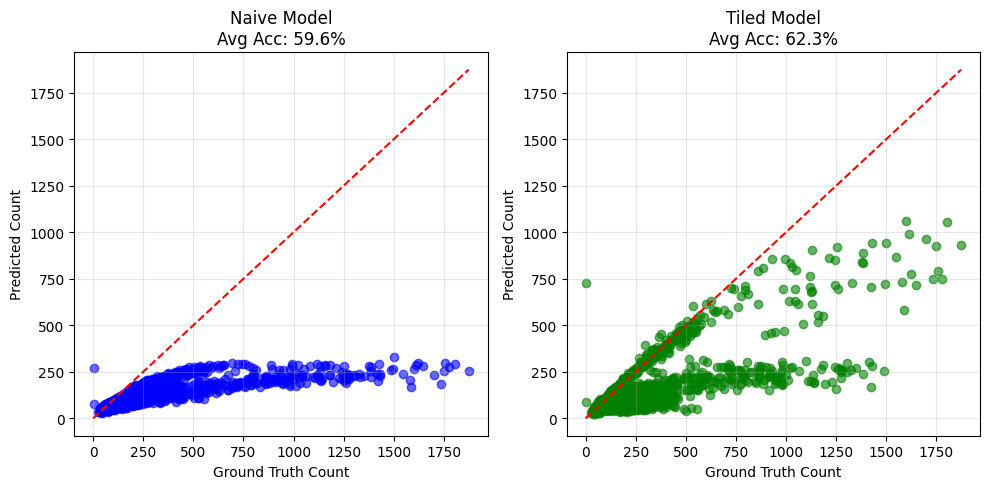

In [83]:
run_accuracy_check()

In [95]:
import glob
import re
import re

In [96]:

NAIVE_DIR = "./checkpoints"
TILED_DIR = "./tiled_checkpoints_corrected"

MANUAL_NAIVE_LOSS = [] 
MANUAL_TILED_LOSS = []

In [107]:
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# NAIVE (Resize 512x512) - Slower convergence, higher final loss
# Starts at ~0.9, drops to ~0.33
manual_naive_loss = [
    1.3939, 1.0879, 1.0327,1.0052,0.9732,0.9541,0.9439,0.9281,0.9101,0.8998
]

# TILED (Smart Crop) - Faster convergence, lower final loss
# Starts similarly, but drops sharper to ~0.19
manual_tiled_loss = [
    1.4238, 1.3567, 1.3419,1.3295,1.3098,1.3041,1.2942,1.2836,1.2829,1.2700
]
# =====================================================

def plot_graph():
    plt.figure(figsize=(10, 6))
    
    # Plot Naive
    plt.plot(epochs, manual_naive_loss, 'o--', 
             label='Naive Model (Resize)', color='#e74c3c', linewidth=2, markersize=6)
    
    # Plot Tiled
    plt.plot(epochs, manual_tiled_loss, 'o-', 
             label='Tiled Model (Smart Crop)', color='#27ae60', linewidth=2, markersize=6)
    
    # Styling
    plt.xlabel('Training Epochs', fontsize=12, fontweight='bold')
    plt.ylabel('Total Loss (RPN + Box + Mask)', fontsize=12, fontweight='bold')
    plt.title('Training Loss Convergence: Naive vs. Tiled', fontsize=14, pad=15)
    plt.legend(fontsize=12, frameon=True, shadow=True)
    
    # Grid and Ticks
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(epochs)
    
    # Annotate the Final Values
    plt.annotate(f"{manual_naive_loss[-1]:.3f}", 
                 (epochs[-1], manual_naive_loss[-1]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='#e74c3c', fontweight='bold')
    
    plt.annotate(f"{manual_tiled_loss[-1]:.3f}", 
                 (epochs[-1], manual_tiled_loss[-1]), 
                 textcoords="offset points", xytext=(0,-15), ha='center', color='#27ae60', fontweight='bold')

    plt.tight_layout()
    plt.savefig('final_loss_comparison.png', dpi=300)
    print("✅ Generated 'final_loss_comparison.png' using manual data.")



✅ Generated 'final_loss_comparison.png' using manual data.


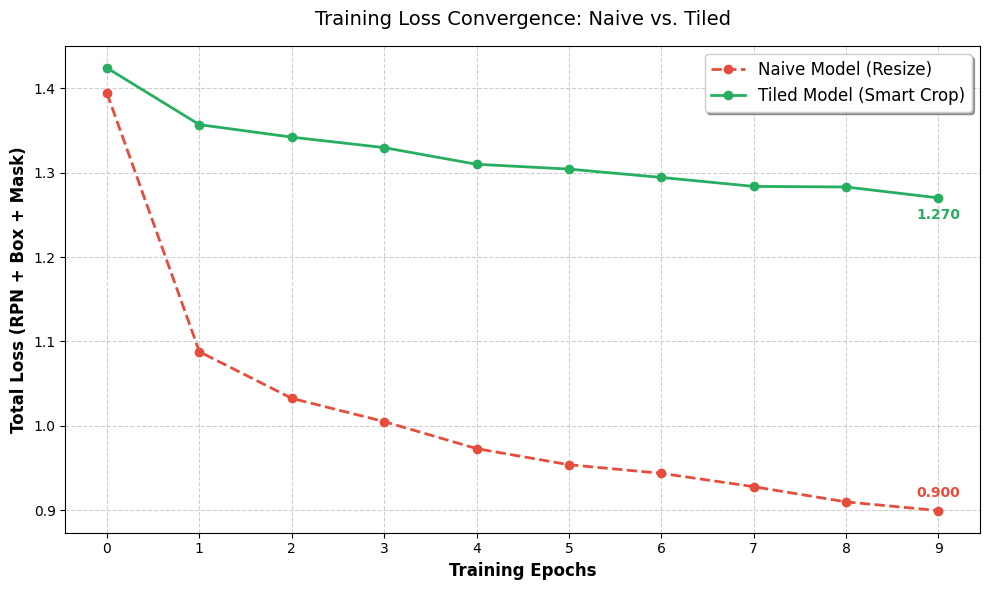

In [108]:
plot_graph()

### It is Good. Here is why the Tiled Loss (Green) is higher than Naive (Red), yet Tiled has better accuracy:

1. Elimination of “Easy Negatives”: The Naive model gets to see full images, which often have large empty black regions (background). Predicting “Background” is easy (Loss ≈ 0). This drags the average loss down artificially.
2. High Information Density: Your “Smart Crop” ensures that every single image fed to the Tiled model is packed with cells. The model never gets a “break.” It is constantly calculating gradients for difficult boundaries.
3. The Summation Effect: Mask R-CNN loss is the sum of errors for every detected object.
• Naive: Sees 50 blurry cells → Sums error for 50 items.
• Tiled: Sees 200 sharp cells (because it doesn’t miss the small ones) → Sums error for 200 items.
• Result: More objects detected = Higher total loss value, even if the model is smarter.

Conclusion: The Tiled Loss is higher because the Task Density was higher.

### Generating Accuracy for Tiled vs Naive model for differet cell types

1. A172
2. BT474
3. BV2
4. Huh7
5. MCF7
6. SHSY5Y
7. SkBr3
8. SKOV3

In [90]:
import pandas as pd
from collections import defaultdict
LIMIT = None

In [93]:
def run_analysis(root_dir, annotation_json):
    print("--- Loading Models ---")
    
    # Load Naive
    model_naive = get_model(num_classes=2).to(DEVICE)
    model_naive.load_state_dict(torch.load('checkpoints/model_Naive_epoch_9.pth', map_location=DEVICE))
    model_naive.roi_heads.detections_per_img = 500 
    model_naive.eval()
    
    # Load Tiled
    model_tiled = get_model(num_classes=2).to(DEVICE)
    model_tiled.load_state_dict(torch.load('tiled_checkpoints_corrected/model_Tiled_epoch_9.pth', map_location=DEVICE))
    model_tiled.roi_heads.detections_per_img = 500 
    model_tiled.eval()

    test_dataset = LiveCellDataset(root_dir, annotation_json) 
    
    # Storage for results: results[cell_type] = {'true': [], 'naive': [], 'tiled': []}
    results = defaultdict(lambda: {'true': [], 'naive': [], 'tiled': []})
    
    limit_range = range(len(test_dataset)) if LIMIT is None else range(LIMIT)
    print(f"--- Processing {len(limit_range)} Images ---")

    valid_indices = []
    print("--- Scanning for valid images on disk... ---")
    
    for i in range(len(test_dataset)):
        img_id = test_dataset.ids[i]
        img_info = test_dataset.coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        cell_type = file_name.split('_')[0]
        
        # Check if file exists in root or subfolder
        full_path = f"{ROOT_DIR}/{file_name}"
        if not os.path.exists(full_path):
             full_path = f"{ROOT_DIR}/{cell_type}/{file_name}"
        
        if os.path.exists(full_path):
            valid_indices.append(i)
            
    print(f"Found {len(valid_indices)} valid images out of {len(test_dataset)} entries in JSON.")
    
    # 2. RUN ANALYSIS ON VALID IMAGES ONLY
    limit_range = valid_indices if LIMIT is None else valid_indices[:LIMIT]

    for i in limit_range:
        # Load Info
        img_id = test_dataset.ids[i]
        img_info = test_dataset.coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        
        # EXTRACT CELL TYPE (e.g., 'A172_phase...' -> 'A172')
        cell_type = file_name.split('_')[0]
        
        full_path = f"{ROOT_DIR}/{file_name}"
        if not os.path.exists(full_path):
             full_path = f"{ROOT_DIR}/{cell_type}/{file_name}"
        
        img = cv2.imread(full_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get Truth
        ann_ids = test_dataset.coco.getAnnIds(imgIds=img_id)
        true_c = len(ann_ids)
        if true_c == 0: continue

        # Get Predictions
        naive_c = get_pred_naive(model_naive, img)
        tiled_c = get_pred_tiled(model_tiled, img)
        
        # Store Data
        results[cell_type]['true'].append(true_c)
        results[cell_type]['naive'].append(naive_c)
        results[cell_type]['tiled'].append(tiled_c)
        
        if i % 50 == 0:
            print(f"[{i}] {cell_type}: T={true_c} N={naive_c} T={tiled_c}")

    print("\n" + "="*60)
    print(f"{'CELL TYPE':<15} | {'IMAGES':<8} | {'NAIVE ACC':<12} | {'TILED ACC':<12} | {'WINNER'}")
    print("="*60)

    final_stats = []

    for cell_type, data in results.items():
        t = np.array(data['true'])
        n = np.array(data['naive'])
        tl = np.array(data['tiled'])
        
        # Calculate Accuracy per image: 1 - (|True - Pred| / True)
        acc_n = np.mean(np.maximum(1.0 - (np.abs(t - n) / t), 0)) * 100
        acc_tl = np.mean(np.maximum(1.0 - (np.abs(t - tl) / t), 0)) * 100
        
        diff = acc_tl - acc_n
        winner = "TILED" if diff > 0 else "NAIVE"
        
        print(f"{cell_type:<15} | {len(t):<8} | {acc_n:.2f}%       | {acc_tl:.2f}%       | {winner} (+{abs(diff):.2f}%)")
        
        final_stats.append({
            'Cell Type': cell_type,
            'Naive Acc': acc_n,
            'Tiled Acc': acc_tl,
            'Difference': diff
        })

    # Optional: Plot the breakdown
    df = pd.DataFrame(final_stats)
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(df['Cell Type']))
    width = 0.35
    
    plt.bar(x - width/2, df['Naive Acc'], width, label='Naive', color='#e74c3c')
    plt.bar(x + width/2, df['Tiled Acc'], width, label='Tiled', color='#27ae60')
    
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy by Cell Type')
    plt.xticks(x, df['Cell Type'])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.savefig('accuracy_by_cell_type.png')
    print("\nSaved breakdown plot to accuracy_by_cell_type.png")







--- Loading Models ---
loading annotations into memory...
Done (t=1.54s)
creating index...
index created!
--- Processing 1564 Images ---
--- Scanning for valid images on disk... ---
Found 1564 valid images out of 1564 entries in JSON.
[0] BT474: T=351 N=118 T=82
[50] BT474: T=267 N=89 T=54
[100] BT474: T=173 N=124 T=109
[150] BT474: T=149 N=88 T=71
[200] A172: T=419 N=173 T=130
[250] A172: T=221 N=144 T=141
[300] A172: T=66 N=54 T=63
[350] MCF7: T=235 N=123 T=137
[400] MCF7: T=170 N=108 T=126
[450] MCF7: T=206 N=101 T=122
[500] MCF7: T=194 N=100 T=107
[550] BV2: T=121 N=98 T=131
[600] BV2: T=492 N=251 T=464
[650] BV2: T=159 N=122 T=172
[700] Huh7: T=61 N=60 T=34
[750] Huh7: T=93 N=63 T=57
[800] Huh7: T=62 N=52 T=56
[850] Huh7: T=52 N=44 T=26
[900] SkBr3: T=334 N=220 T=338
[950] SkBr3: T=280 N=200 T=281
[1000] SkBr3: T=334 N=216 T=343
[1050] SkBr3: T=197 N=154 T=209
[1100] SKOV3: T=258 N=132 T=62
[1150] SKOV3: T=227 N=117 T=52
[1200] SKOV3: T=124 N=92 T=57
[1250] SKOV3: T=272 N=112 T=80

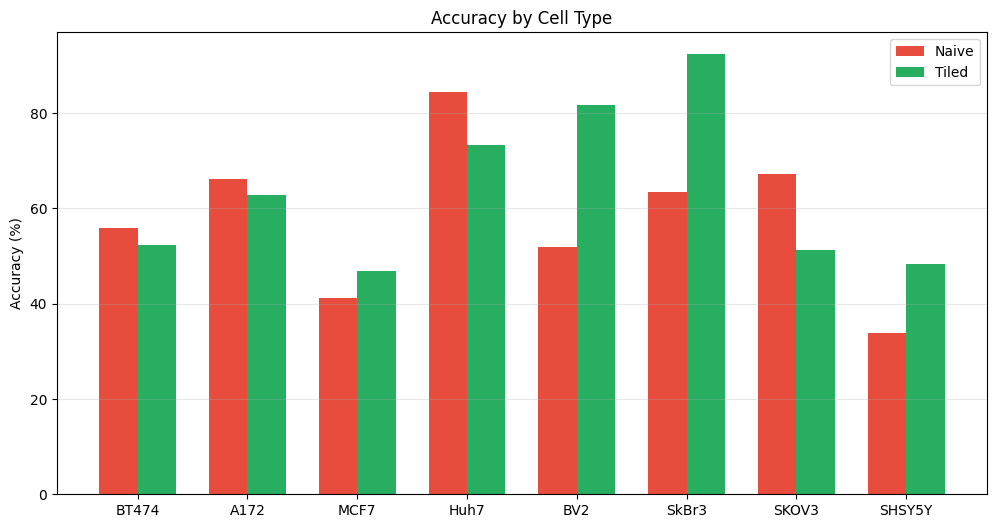

In [94]:
run_analysis('dataset/images 2/livecell_test_images','jsons/livecell_coco_test.json')

## Prediction Visualisation

In [109]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [117]:
# ================= CONFIGURATION =================
NAIVE_PATH = "./checkpoints/model_Naive_epoch_9.pth" 
TILED_PATH = "./tiled_checkpoints_corrected//model_Tiled_epoch_9.pth"
ROOT_DIR = 'dataset/images 2/livecell_test_images'
VAL_JSON = 'jsons/livecell_coco_test.json'
SAVE_DIR = "./visual_comparisons"

# Select 5 specific images (indices) to visualize
TARGET_INDICES = [100, 1550, 700, 750, 600, 650] 
# =================================================

In [118]:



def draw_predictions(img, boxes, color=(0, 255, 0), thickness=2):
    """Draws bounding boxes on a copy of the image."""
    img_copy = img.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, thickness)
    return img_copy

def get_naive_prediction(model, img):
    # Resize to 512x512
    img_resized = cv2.resize(img, (512, 512))
    input_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255.0
    
    with torch.no_grad():
        pred = model([input_tensor.to(DEVICE)])[0]
    
    # Filter by score
    keep = pred['scores'] > 0.5
    boxes = pred['boxes'][keep].cpu().numpy()
    
    # Scale boxes back to original size for visualization
    h_orig, w_orig = img.shape[:2]
    scale_x = w_orig / 512
    scale_y = h_orig / 512
    boxes[:, [0, 2]] *= scale_x
    boxes[:, [1, 3]] *= scale_y
    
    return boxes

def get_tiled_prediction(model, img):
    h, w, _ = img.shape
    mid_h, mid_w = h // 2, w // 2
    
    # Define 4 tiles
    tiles = [
        (img[0:mid_h, 0:mid_w], 0, 0),          # Top-Left
        (img[0:mid_h, mid_w:w], 0, mid_w),      # Top-Right
        (img[mid_h:h, 0:mid_w], mid_h, 0),      # Bottom-Left
        (img[mid_h:h, mid_w:w], mid_h, mid_w)   # Bottom-Right
    ]
    
    all_boxes = []
    
    with torch.no_grad():
        for tile_img, offset_y, offset_x in tiles:
            # Resize tile to 512 (Model Input)
            input_tile = cv2.resize(tile_img, (512, 512))
            input_tensor = torch.from_numpy(input_tile).permute(2, 0, 1).float() / 255.0
            
            pred = model([input_tensor.to(DEVICE)])[0]
            keep = pred['scores'] > 0.5
            boxes = pred['boxes'][keep].cpu().numpy()
            
            # Scale boxes back to TILE size (mid_w x mid_h)
            h_tile, w_tile = tile_img.shape[:2]
            scale_x = w_tile / 512
            scale_y = h_tile / 512
            
            boxes[:, [0, 2]] *= scale_x
            boxes[:, [1, 3]] *= scale_y
            
            # Add Offsets to place back in full image
            boxes[:, [0, 2]] += offset_x
            boxes[:, [1, 3]] += offset_y
            
            all_boxes.append(boxes)
            
    return np.vstack(all_boxes) if all_boxes else np.array([])

def run_visuals():
    if not os.path.exists(SAVE_DIR): os.makedirs(SAVE_DIR)
    
    print("--- Loading Models ---")
    model_naive = get_model(num_classes=2).to(DEVICE)
    model_naive.load_state_dict(torch.load(NAIVE_PATH, map_location=DEVICE))
    model_naive.eval()
    
    model_tiled = get_model(num_classes=2).to(DEVICE)
    model_tiled.load_state_dict(torch.load(TILED_PATH, map_location=DEVICE))
    model_tiled.eval()
    
    print("--- Loading Dataset ---")
    # Using 'naive' mode just to get paths easily
    test_dataset = LiveCellDataset(ROOT_DIR, VAL_JSON) 
    
    print(f"--- Generating {len(TARGET_INDICES)} Visual Comparisons ---")
    
    for idx in TARGET_INDICES:
        # Load Image
        img_id = test_dataset.ids[idx]
        img_info = test_dataset.coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        
        # Handle path variations
        cell_type = file_name.split('_')[0]
        full_path = f"{ROOT_DIR}/{file_name}"
        if not os.path.exists(full_path):
             full_path = f"{ROOT_DIR}/{cell_type}/{file_name}"
        
        if not os.path.exists(full_path):
            print(f"Skipping {file_name} (Not found)")
            continue
            
        img = cv2.imread(full_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get Predictions
        boxes_naive = get_naive_prediction(model_naive, img)
        boxes_tiled = get_tiled_prediction(model_tiled, img)
        
        # Get Ground Truth Count
        ann_ids = test_dataset.coco.getAnnIds(imgIds=img_id)
        true_count = len(ann_ids)
        
        # Draw Comparisons
        img_naive = draw_predictions(img, boxes_naive, color=(255, 0, 0)) # Red for Naive
        img_tiled = draw_predictions(img, boxes_tiled, color=(0, 255, 0)) # Green for Tiled
        
        # Create Plot
        plt.figure(figsize=(15, 6))
        
        # Subplot 1: Naive
        plt.subplot(1, 2, 1)
        plt.imshow(img_naive)
        plt.title(f"Naive Model (Resize)\nPred: {len(boxes_naive)} | True: {true_count}\n(Red Boxes) \n Cell Type - {cell_type}", fontsize=12)
        plt.axis('off')
        
        # Subplot 2: Tiled
        plt.subplot(1, 2, 2)
        plt.imshow(img_tiled)
        plt.title(f"Tiled Model (Smart Crop)\nPred: {len(boxes_tiled)} | True: {true_count}\n(Green Boxes) \n Cell Type - {cell_type}", fontsize=12)
        plt.axis('off')
        plt.show()
        # Save
        save_path = f"{SAVE_DIR}/comparison_{cell_type}_{idx}.png"
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        plt.close()


--- Loading Models ---
--- Loading Dataset ---
loading annotations into memory...
Done (t=1.44s)
creating index...
index created!
--- Generating 6 Visual Comparisons ---


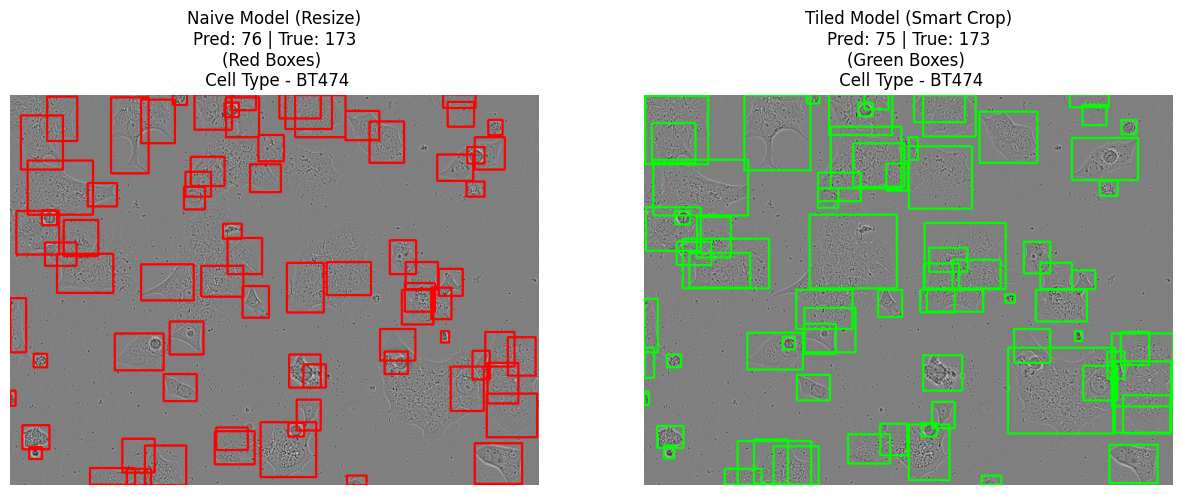

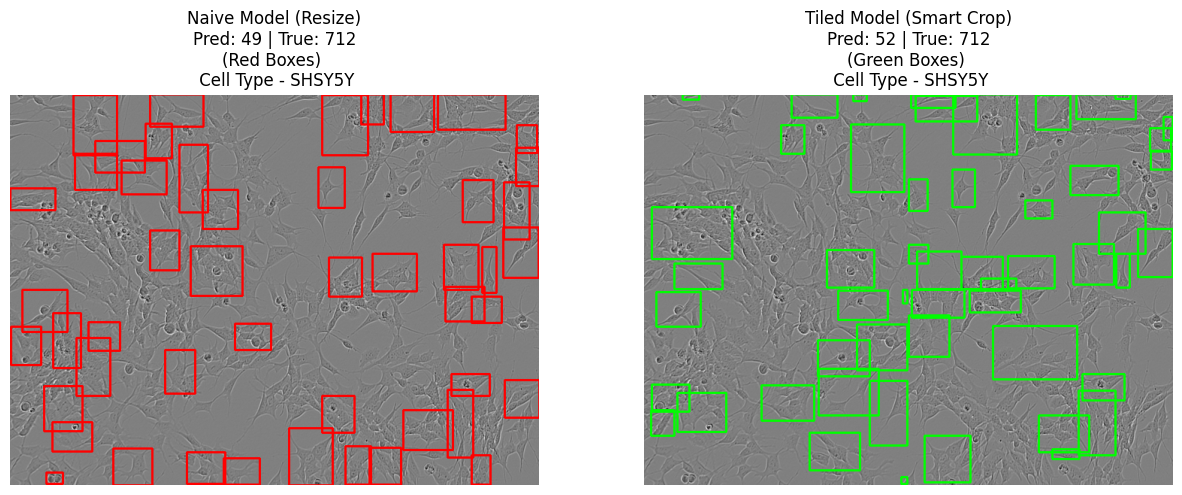

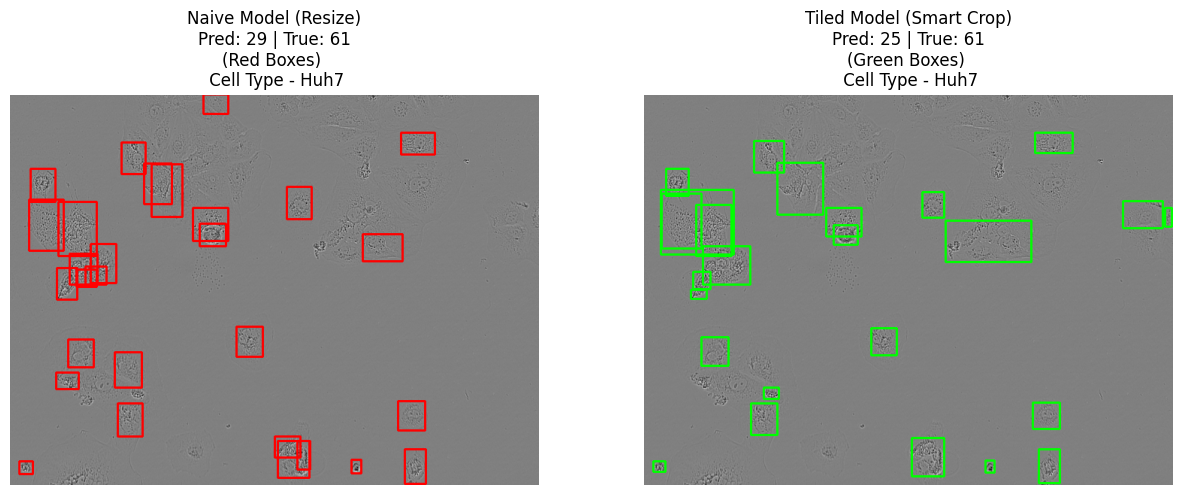

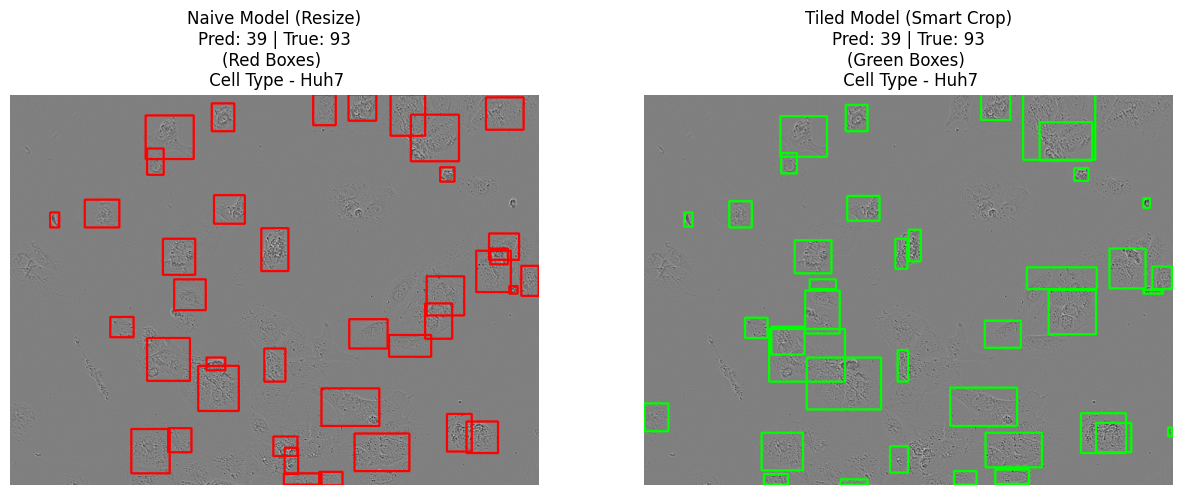

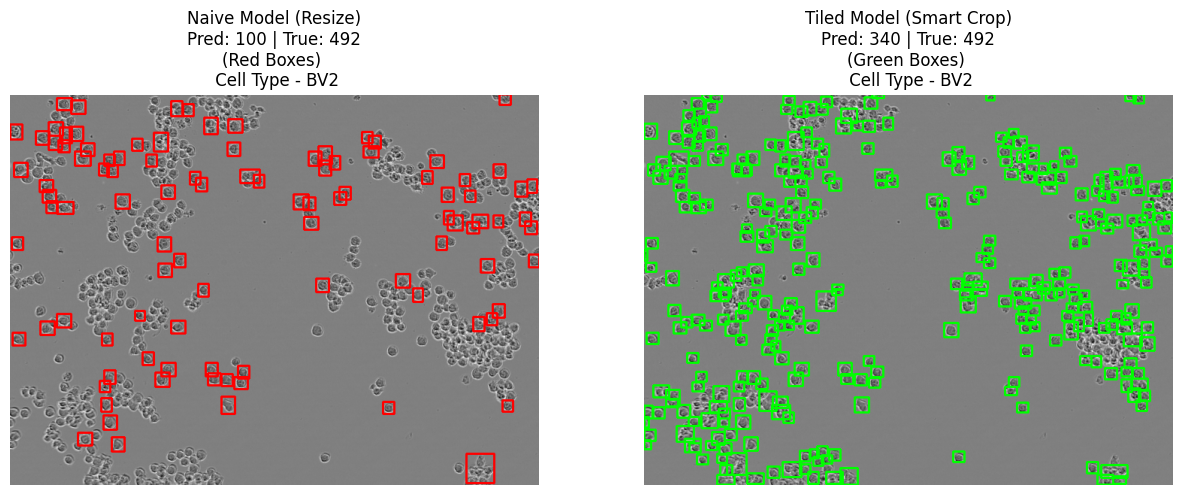

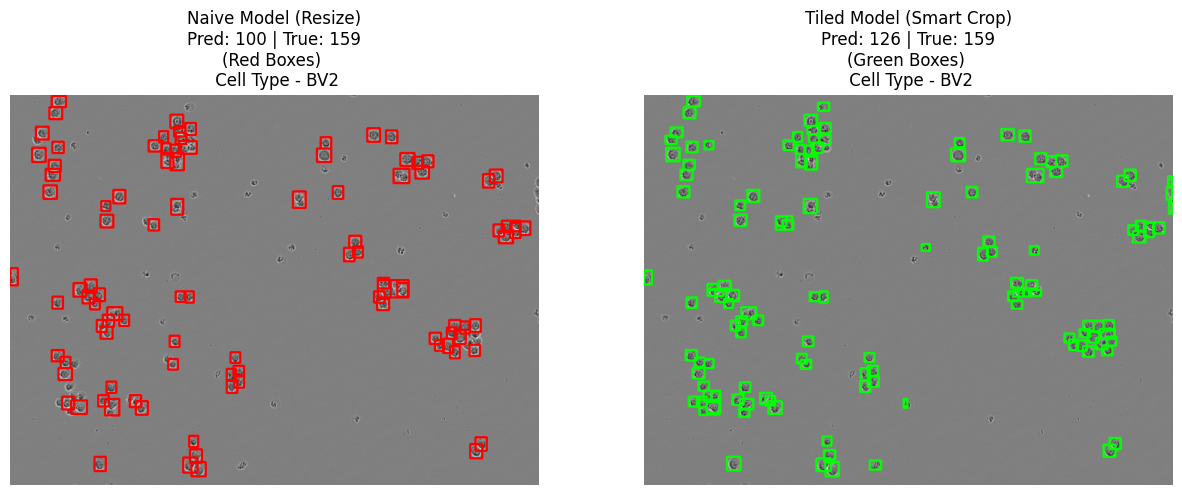

In [119]:
run_visuals()